In [1]:
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from torch.optim import Adam

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names, build_input_features

from deepctr_torch.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
import os

In [4]:
def sparse2tensor(sparse_mat):
    
    coo = sparse_mat.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()


In [5]:
root = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens'

In [6]:


user_movie = pd.read_feather(os.path.join(root, 'user_movie_fea.ftr'), use_threads=True)
user_list = user_movie.user.value_counts().index.to_numpy()
user_list = np.sort(user_list)

movie_list = user_movie.movie.value_counts().index.to_numpy()
movie_list = np.sort(movie_list).astype(str)

n_users = user_list.shape[0]
n_movies = movie_list.shape[0]

In [7]:
data = user_movie

In [8]:
def genre_split(x):
    key_ans = x
    for key in key_ans:
        if key not in genre_key2index:
            genre_key2index[key] = len(genre_key2index) + 1
    return list(map(lambda x: genre_key2index[x], key_ans))

def user_inter_split(x):
    key_ans = x
    for key in key_ans:
        if key not in user_inter_key2index:
            user_inter_key2index[key] = len(user_inter_key2index) + 1
    return list(map(lambda x: user_inter_key2index[x], key_ans))

def movie_inter_split(x):
    key_ans = x
    for key in key_ans:
        if key not in movie_inter_key2index:
            movie_inter_key2index[key] = len(movie_inter_key2index) + 1
    return list(map(lambda x: movie_inter_key2index[x], key_ans))

In [9]:
genre_key2index = {}
genre_list = list(map(genre_split, data['genre'].values))
genre_length = np.array(list(map(len, genre_list)))
genre_max_len = max(genre_length)
genre_list = pad_sequences(genre_list, maxlen=genre_max_len, padding='post', )

In [10]:
user_inter_key2index = {}
user_inter_list = list(map(user_inter_split, data['user_inter'].values))
user_inter_length = np.array(list(map(len, user_inter_list)))
user_inter_max_len = max(user_inter_length)
user_inter_list = pad_sequences(user_inter_list, maxlen=user_inter_max_len, padding='post', )

In [11]:
movie_inter_key2index = {}
movie_inter_list = list(map(movie_inter_split, data['movie_inter'].values))
movie_inter_length = np.array(list(map(len, movie_inter_list)))
movie_inter_max_len = max(movie_inter_length)
movie_inter_list = pad_sequences(movie_inter_list, maxlen=movie_inter_max_len, padding='post', )

In [12]:
data

,user,movie,rate,age,occupation,genre,movie_inter,user_inter
0,195,241,3,4,2,[4],"[14, 16, 25, 31, 65, 74, 83, 149, 156, 175, 19...","[1, 13, 18, 57, 62, 64, 77, 78, 86, 97, 173, 1..."
1,185,301,3,3,3,"[5, 9, 12, 15]","[35, 38, 39, 46, 110, 111, 133, 139, 169, 172,...","[14, 53, 55, 83, 108, 129, 134, 140, 144, 158,..."
2,21,376,1,2,2,"[3, 4]","[27, 32, 60, 98, 99, 104, 116, 133, 177, 189, ...","[4, 7, 55, 63, 94, 101, 102, 124, 157, 196, 19..."
3,243,50,2,2,0,"[7, 13, 16, 17]","[22, 41, 63, 90, 113, 123, 124, 127, 174, 181,...","[42, 61, 91, 93, 108, 127, 173, 177, 183, 193,..."
4,165,345,1,4,7,"[5, 7]","[7, 63, 93, 108, 177, 196, 221, 266, 267, 275,...","[32, 38, 60, 106, 125, 126, 128, 142, 169, 204..."
...,...,...,...,...,...,...,...,...
99995,879,475,3,1,5,[4],"[10, 18, 21, 55, 86, 108, 109, 124, 207, 209, ...","[55, 86, 91, 93, 108, 129, 177, 220, 221, 248,..."
99996,715,203,5,3,4,"[4, 14]","[2, 34, 39, 46, 106, 110, 112, 132, 133, 139, ...","[5, 6, 17, 58, 59, 84, 127, 150, 193, 209, 229..."
99997,275,1089,1,2,5,[15],[1682],"[55, 91, 93, 108, 129, 177, 221, 266, 267, 279..."
99998,12,224,2,4,7,"[3, 4]","[5, 15, 17, 47, 50, 59, 89, 90, 122, 127, 227,...","[6, 58, 63, 93, 94, 101, 150, 177, 193, 200, 2..."


In [13]:
fixlen_feature_columns_1 = [SparseFeat(feat, data[feat].nunique(), embedding_dim=50) for feat in user_movie.columns[:2]]
fixlen_feature_columns_2 = [SparseFeat(feat, data[feat].nunique(), embedding_dim=50) for feat in user_movie.columns[3:5]]
fixlen_feature_columns = fixlen_feature_columns_1 + fixlen_feature_columns_2

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genre', vocabulary_size=len(
    genre_key2index) + 1, embedding_dim=50), maxlen=genre_max_len, combiner='mean'),
                          VarLenSparseFeat(SparseFeat('user_inter', vocabulary_size=len(
    user_inter_key2index) + 1, embedding_dim=50), maxlen=user_inter_max_len, combiner='mean'),
                          VarLenSparseFeat(SparseFeat('movie_inter', vocabulary_size=len(
    movie_inter_key2index) + 1, embedding_dim=50), maxlen=movie_inter_max_len, combiner='mean')
                         ]  # Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [14]:
model_input = {name: data[name] for name in user_movie.columns[:5] if name !='rate'}  #
model_input["genre"] = genre_list
model_input["user_inter"] = user_inter_list
model_input["movie_inter"] = movie_inter_list

In [15]:
genre_list =[]
user_inter_list = []
movie_inter_list = []

In [16]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

cuda ready...


In [43]:
# feature_index = build_input_features(linear_feature_columns + dnn_feature_columns)
# x = [model_input[feature] for feature in feature_index]
# for i in range(len(x)):
#     if len(x[i].shape) == 1:
#         x[i] = np.expand_dims(x[i], axis=1)
# sparse_x = [sparse.csr_matrix(fea) for fea in x]
# sparse_x = hstack(sparse_x)
# sparse_x = sparse_x.tocsr()
# sparse.save_npz('C:/Users/bbb50/Desktop/Python/hw3/Movielens/dctr_x.npz', sparse_x, True) 

In [29]:
sparse_x = sparse.load_npz('C:/Users/bbb50/Desktop/Python/hw3/Movielens/dctr_x.npz').astype(np.int64)

In [30]:
target = data.rate.values

In [31]:

train_path = os.path.join(root, 'train')
val_path = os.path.join(root, 'val')
test_path = os.path.join(root, 'test')


In [32]:
from deepctr_torch.models import DeepFM
def DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/deepfm/' + str(i) + '/deepfm_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])    
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/deepfm/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [33]:
from deepctr_torch.models.afm import AFM
def AFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = AFM(linear_feature_columns, dnn_feature_columns, afm_dropout=0.2, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0008), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/AFM/' + str(i) + '/AFM_{epoch}-{val_mse:.3f}.ckpt'

    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/AFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [34]:
from deepctr_torch.models.ccpm import CCPM
def CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = CCPM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/CCPM/' + str(i) + '/CCPM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/CCPM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [35]:
from deepctr_torch.models.pnn import PNN
def IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, use_inner=True, use_outter=False,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/IPNN/' + str(i) + '/IPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y  , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/IPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [36]:
from deepctr_torch.models.pnn import PNN
def OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005,use_inner=False, use_outter=True,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/OPNN/' + str(i) + '/OPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/OPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [37]:
from deepctr_torch.models.wdl import WDL
def WDL_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0008), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/wide_deep/' + str(i) + '/wide_deep_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/wide_deep/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [38]:
from  deepctr_torch.models.nfm import NFM
def NFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = NFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.0003), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/NFM/' + str(i) + '/NFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/NFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [39]:
from deepctr_torch.models.dcn import DCN
def DCN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DCN(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/DCN/' + str(i) + '/DCN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/DCN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [40]:
from deepctr_torch.models.xdeepfm import xDeepFM
def xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/xDeepFM/' + str(i) + '/xDeepFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/xDeepFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [41]:
from deepctr_torch.models.difm import DIFM
def DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DIFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, l2_reg_dnn = 0.0005, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.00005), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/DIFM/' + str(i) + '/DIFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=10, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=100, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/DIFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [42]:
from matplotlib import pyplot as plt

number: 1
DeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
7s - loss:  5.7585 - mse:  5.7563 - val_mse:  3.8301
Epoch 2/100
7s - loss:  0.9568 - mse:  0.9567 - val_mse:  0.9124
Epoch 3/100
7s - loss:  0.8669 - mse:  0.8669 - val_mse:  0.9082
Epoch 4/100
6s - loss:  0.8561 - mse:  0.8561 - val_mse:  0.9048
Epoch 5/100
7s - loss:  0.8477 - mse:  0.8480 - val_mse:  0.9083
Epoch 6/100
7s - loss:  0.8368 - mse:  0.8370 - val_mse:  0.9071
Epoch 7/100
6s - loss:  0.8388 - mse:  0.8392 - val_mse:  0.9140
Epoch 8/100
6s - loss:  0.8283 - mse:  0.8281 - val_mse:  0.9207
Epoch 9/100
6s - loss:  0.8175 - mse:  0.8176 - val_mse:  0.9173
Epoch 10/100
4s - loss:  0.8165 - mse:  0.8163 - val_mse:  0.9069
Epoch 11/100
4s - loss:  0.7996 - mse:  0.7994 - val_mse:  0.9026
Epoch 12/100
4s - loss:  0.7839 - mse:  0.7837 - val_mse:  0.9085
Epoch 13/100
4s - loss:  0.7755 - mse:  0.7756 - val_mse:  0.8971
Epoch 14/100
4s - loss:  0.7632 - mse:  0.7631 - val_mse

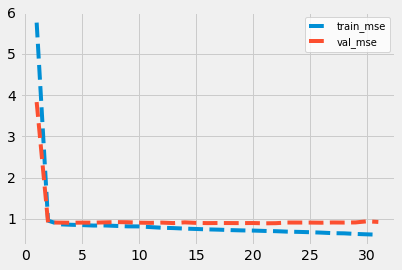

AFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  7.6519 - mse:  7.6386 - val_mse:  1.2520
Epoch 2/100
3s - loss:  1.1671 - mse:  1.1664 - val_mse:  1.1442
Epoch 3/100
3s - loss:  1.0990 - mse:  1.0982 - val_mse:  1.0876
Epoch 4/100
3s - loss:  1.0329 - mse:  1.0321 - val_mse:  1.0105
Epoch 5/100
4s - loss:  0.9357 - mse:  0.9355 - val_mse:  0.9360
Epoch 6/100
3s - loss:  0.8779 - mse:  0.8777 - val_mse:  0.9146
Epoch 7/100
3s - loss:  0.8540 - mse:  0.8537 - val_mse:  0.9065
Epoch 8/100
3s - loss:  0.8406 - mse:  0.8405 - val_mse:  0.9065
Epoch 9/100
3s - loss:  0.8301 - mse:  0.8299 - val_mse:  0.8988
Epoch 10/100
3s - loss:  0.8216 - mse:  0.8220 - val_mse:  0.9015
Epoch 11/100
4s - loss:  0.8131 - mse:  0.8128 - val_mse:  0.8947
Epoch 12/100
3s - loss:  0.8047 - mse:  0.8045 - val_mse:  0.8971
Epoch 13/100
4s - loss:  0.7964 - mse:  0.7959 - val_mse:  0.8921
Epoch 14/100
4s - loss:  0.7874 - mse:  0.7871 - val_mse:  0.8929
Epo

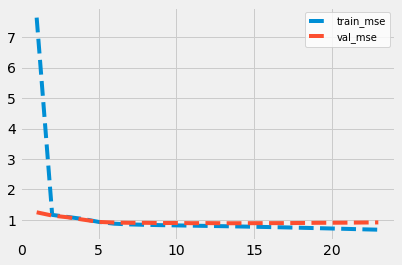

CCPM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  8.6147 - mse:  8.6115 - val_mse:  7.6846
Epoch 2/100
5s - loss:  1.6274 - mse:  1.6276 - val_mse:  1.3074
Epoch 3/100
5s - loss:  1.2697 - mse:  1.2694 - val_mse:  1.2768
Epoch 4/100
6s - loss:  1.2400 - mse:  1.2399 - val_mse:  1.2457
Epoch 5/100
5s - loss:  1.2098 - mse:  1.2100 - val_mse:  1.2154
Epoch 6/100
5s - loss:  1.1800 - mse:  1.1799 - val_mse:  1.1839
Epoch 7/100
5s - loss:  1.1458 - mse:  1.1455 - val_mse:  1.1553
Epoch 8/100
5s - loss:  1.1074 - mse:  1.1072 - val_mse:  1.1074
Epoch 9/100
5s - loss:  1.0615 - mse:  1.0611 - val_mse:  1.0608
Epoch 10/100
8s - loss:  1.0129 - mse:  1.0132 - val_mse:  1.0194
Epoch 11/100
8s - loss:  0.9649 - mse:  0.9647 - val_mse:  0.9757
Epoch 12/100
8s - loss:  0.9244 - mse:  0.9243 - val_mse:  0.9453
Epoch 13/100
8s - loss:  0.8923 - mse:  0.8923 - val_mse:  0.9235
Epoch 14/100
8s - loss:  0.8671 - mse:  0.8670 - val_mse:  0.9112
Ep

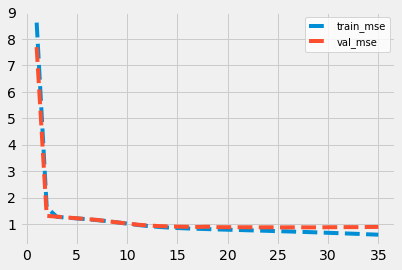

IPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  8.9473 - mse:  8.9321 - val_mse:  1.2134
Epoch 2/100
4s - loss:  1.1031 - mse:  1.1026 - val_mse:  1.0467
Epoch 3/100
4s - loss:  0.9794 - mse:  0.9790 - val_mse:  0.9615
Epoch 4/100
4s - loss:  0.9079 - mse:  0.9078 - val_mse:  0.9176
Epoch 5/100
4s - loss:  0.8711 - mse:  0.8713 - val_mse:  0.9000
Epoch 6/100
4s - loss:  0.8535 - mse:  0.8532 - val_mse:  0.8938
Epoch 7/100
4s - loss:  0.8447 - mse:  0.8447 - val_mse:  0.8920
Epoch 8/100
4s - loss:  0.8399 - mse:  0.8396 - val_mse:  0.8916
Epoch 9/100
4s - loss:  0.8369 - mse:  0.8372 - val_mse:  0.8917
Epoch 10/100
4s - loss:  0.8347 - mse:  0.8342 - val_mse:  0.8922
Epoch 11/100
4s - loss:  0.8336 - mse:  0.8332 - val_mse:  0.8925
Epoch 12/100
4s - loss:  0.8325 - mse:  0.8325 - val_mse:  0.8929
Epoch 13/100
4s - loss:  0.8315 - mse:  0.8312 - val_mse:  0.8935
Epoch 14/100
4s - loss:  0.8310 - mse:  0.8311 - val_mse:  0.8946
Ep

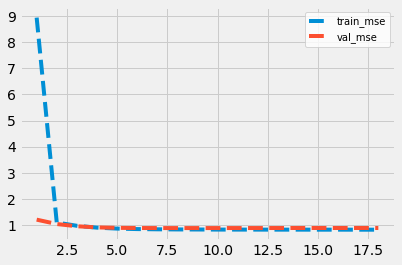

OPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  3.2538 - mse:  3.2487 - val_mse:  0.9222
Epoch 2/100
4s - loss:  0.8787 - mse:  0.8789 - val_mse:  0.9054
Epoch 3/100
4s - loss:  0.8616 - mse:  0.8614 - val_mse:  0.8994
Epoch 4/100
4s - loss:  0.8564 - mse:  0.8561 - val_mse:  0.8960
Epoch 5/100
4s - loss:  0.8534 - mse:  0.8539 - val_mse:  0.8976
Epoch 6/100
4s - loss:  0.8517 - mse:  0.8525 - val_mse:  0.9067
Epoch 7/100
4s - loss:  0.8511 - mse:  0.8508 - val_mse:  0.8991
Epoch 8/100
4s - loss:  0.8470 - mse:  0.8468 - val_mse:  0.9061
Epoch 9/100
4s - loss:  0.8475 - mse:  0.8477 - val_mse:  0.8970
Epoch 10/100
4s - loss:  0.8455 - mse:  0.8455 - val_mse:  0.8997
Epoch 11/100
4s - loss:  0.8442 - mse:  0.8444 - val_mse:  0.8975
Epoch 12/100
4s - loss:  0.8426 - mse:  0.8425 - val_mse:  0.9008
Epoch 13/100
4s - loss:  0.8382 - mse:  0.8379 - val_mse:  0.8931
Epoch 14/100
4s - loss:  0.8263 - mse:  0.8262 - val_mse:  0.8785
Ep

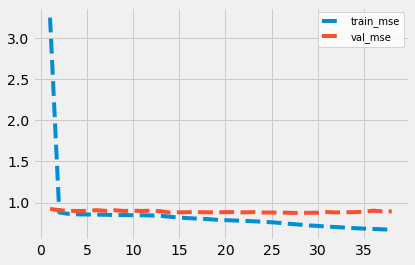

WDL
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
7s - loss:  2.2294 - mse:  2.2273 - val_mse:  0.9218
Epoch 2/100
6s - loss:  0.8780 - mse:  0.8780 - val_mse:  0.9018
Epoch 3/100
6s - loss:  0.8657 - mse:  0.8656 - val_mse:  0.9023
Epoch 4/100
6s - loss:  0.8608 - mse:  0.8607 - val_mse:  0.8988
Epoch 5/100
6s - loss:  0.8585 - mse:  0.8587 - val_mse:  0.9065
Epoch 6/100
6s - loss:  0.8564 - mse:  0.8565 - val_mse:  0.8974
Epoch 7/100
6s - loss:  0.8579 - mse:  0.8583 - val_mse:  0.9072
Epoch 8/100
7s - loss:  0.8548 - mse:  0.8543 - val_mse:  0.9135
Epoch 9/100
6s - loss:  0.8531 - mse:  0.8532 - val_mse:  0.9000
Epoch 10/100
6s - loss:  0.8528 - mse:  0.8525 - val_mse:  0.8982
Epoch 11/100
6s - loss:  0.8506 - mse:  0.8505 - val_mse:  0.8990
Epoch 12/100
6s - loss:  0.8489 - mse:  0.8485 - val_mse:  0.8999
Epoch 13/100
7s - loss:  0.8486 - mse:  0.8488 - val_mse:  0.9003
Epoch 14/100
6s - loss:  0.8481 - mse:  0.8480 - val_mse:  0.9000
Epo

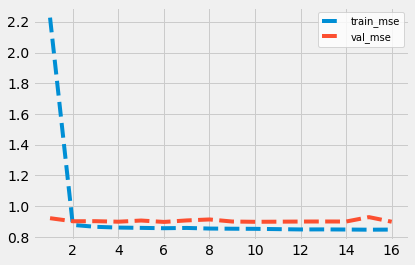

NFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
6s - loss:  5.0523 - mse:  5.0446 - val_mse:  1.0348
Epoch 2/100
6s - loss:  0.9387 - mse:  0.9388 - val_mse:  0.9110
Epoch 3/100
7s - loss:  0.8628 - mse:  0.8622 - val_mse:  0.8916
Epoch 4/100
7s - loss:  0.8434 - mse:  0.8433 - val_mse:  0.8881
Epoch 5/100
7s - loss:  0.8335 - mse:  0.8333 - val_mse:  0.8858
Epoch 6/100
7s - loss:  0.8248 - mse:  0.8247 - val_mse:  0.8833
Epoch 7/100
7s - loss:  0.8179 - mse:  0.8185 - val_mse:  0.8825
Epoch 8/100
7s - loss:  0.8113 - mse:  0.8112 - val_mse:  0.8823
Epoch 9/100
7s - loss:  0.8049 - mse:  0.8049 - val_mse:  0.8829
Epoch 10/100
7s - loss:  0.7986 - mse:  0.7986 - val_mse:  0.8796
Epoch 11/100
7s - loss:  0.7922 - mse:  0.7924 - val_mse:  0.8777
Epoch 12/100
7s - loss:  0.7855 - mse:  0.7851 - val_mse:  0.8764
Epoch 13/100
7s - loss:  0.7787 - mse:  0.7787 - val_mse:  0.8751
Epoch 14/100
7s - loss:  0.7709 - mse:  0.7708 - val_mse:  0.8748
Epo

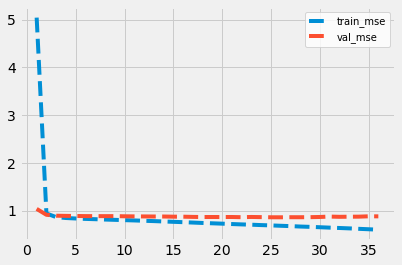

DCN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  7.2457 - mse:  7.2397 - val_mse:  4.0329
Epoch 2/100
4s - loss:  0.9554 - mse:  0.9555 - val_mse:  0.9191
Epoch 3/100
4s - loss:  0.8655 - mse:  0.8654 - val_mse:  0.9164
Epoch 4/100
4s - loss:  0.8489 - mse:  0.8487 - val_mse:  0.9140
Epoch 5/100
4s - loss:  0.8434 - mse:  0.8439 - val_mse:  0.9091
Epoch 6/100
4s - loss:  0.8398 - mse:  0.8395 - val_mse:  0.9332
Epoch 7/100
4s - loss:  0.8359 - mse:  0.8363 - val_mse:  0.9039
Epoch 8/100
4s - loss:  0.8325 - mse:  0.8326 - val_mse:  0.9089
Epoch 9/100
4s - loss:  0.8329 - mse:  0.8328 - val_mse:  0.9048
Epoch 10/100
4s - loss:  0.8296 - mse:  0.8299 - val_mse:  0.9069
Epoch 11/100
4s - loss:  0.8270 - mse:  0.8272 - val_mse:  0.9086
Epoch 12/100
4s - loss:  0.8212 - mse:  0.8208 - val_mse:  0.9129
Epoch 13/100
4s - loss:  0.8169 - mse:  0.8165 - val_mse:  0.9121
Epoch 14/100
4s - loss:  0.8120 - mse:  0.8123 - val_mse:  0.8963
Epo

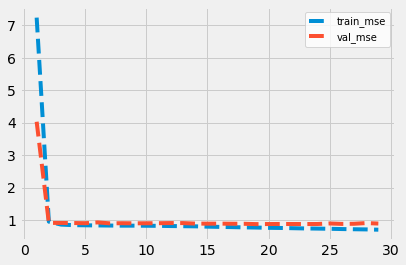

xDeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  13.1274 - mse:  13.1141 - val_mse:  5.9713
Epoch 2/100
5s - loss:  1.1083 - mse:  1.1081 - val_mse:  0.9294
Epoch 3/100
5s - loss:  0.8740 - mse:  0.8741 - val_mse:  0.9105
Epoch 4/100
5s - loss:  0.8543 - mse:  0.8542 - val_mse:  0.9196
Epoch 5/100
6s - loss:  0.8462 - mse:  0.8460 - val_mse:  0.9087
Epoch 6/100
6s - loss:  0.8413 - mse:  0.8416 - val_mse:  0.9078
Epoch 7/100
6s - loss:  0.8361 - mse:  0.8363 - val_mse:  0.9032
Epoch 8/100
6s - loss:  0.8339 - mse:  0.8338 - val_mse:  0.9047
Epoch 9/100
6s - loss:  0.8322 - mse:  0.8325 - val_mse:  0.9056
Epoch 10/100
7s - loss:  0.8319 - mse:  0.8317 - val_mse:  0.9058
Epoch 11/100
6s - loss:  0.8287 - mse:  0.8290 - val_mse:  0.9042
Epoch 12/100
6s - loss:  0.8274 - mse:  0.8276 - val_mse:  0.9019
Epoch 13/100
6s - loss:  0.8273 - mse:  0.8271 - val_mse:  0.9021
Epoch 14/100
6s - loss:  0.8262 - mse:  0.8261 - val_mse:  0.90

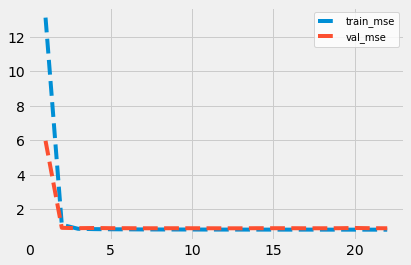

DIFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  11.3773 - mse:  11.3686 - val_mse:  5.5072
Epoch 2/100
4s - loss:  1.1856 - mse:  1.1851 - val_mse:  0.9449
Epoch 3/100
4s - loss:  0.8871 - mse:  0.8868 - val_mse:  0.9117
Epoch 4/100
4s - loss:  0.8639 - mse:  0.8643 - val_mse:  0.9120
Epoch 5/100
4s - loss:  0.8509 - mse:  0.8510 - val_mse:  0.9114
Epoch 6/100
4s - loss:  0.8391 - mse:  0.8395 - val_mse:  0.9350
Epoch 7/100
4s - loss:  0.8276 - mse:  0.8272 - val_mse:  0.9675
Epoch 8/100
4s - loss:  0.8144 - mse:  0.8147 - val_mse:  0.9583
Epoch 9/100
4s - loss:  0.8106 - mse:  0.8106 - val_mse:  0.9285
Epoch 10/100
4s - loss:  0.8003 - mse:  0.8005 - val_mse:  0.9539
Epoch 11/100
4s - loss:  0.7903 - mse:  0.7900 - val_mse:  0.9334
Epoch 12/100
4s - loss:  0.7846 - mse:  0.7848 - val_mse:  0.9562
Epoch 13/100
4s - loss:  0.7800 - mse:  0.7799 - val_mse:  0.9307
Epoch 14/100
4s - loss:  0.7667 - mse:  0.7667 - val_mse:  0.9482


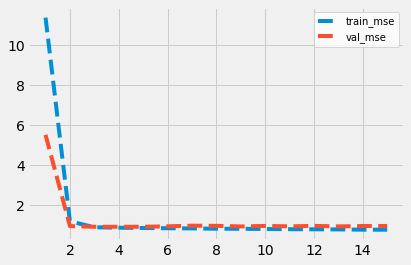

number: 2
DeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.6035 - mse:  5.6004 - val_mse:  3.6384
Epoch 2/100
4s - loss:  0.9541 - mse:  0.9540 - val_mse:  0.9311
Epoch 3/100
4s - loss:  0.8696 - mse:  0.8697 - val_mse:  0.9038
Epoch 4/100
4s - loss:  0.8591 - mse:  0.8588 - val_mse:  0.9235
Epoch 5/100
4s - loss:  0.8536 - mse:  0.8537 - val_mse:  0.9016
Epoch 6/100
4s - loss:  0.8444 - mse:  0.8446 - val_mse:  0.9100
Epoch 7/100
4s - loss:  0.8435 - mse:  0.8433 - val_mse:  0.9399
Epoch 8/100
4s - loss:  0.8385 - mse:  0.8388 - val_mse:  0.9042
Epoch 9/100
4s - loss:  0.8358 - mse:  0.8364 - val_mse:  0.9133
Epoch 10/100
4s - loss:  0.8268 - mse:  0.8267 - val_mse:  0.9129
Epoch 11/100
4s - loss:  0.8240 - mse:  0.8237 - val_mse:  0.9105
Epoch 12/100
4s - loss:  0.8143 - mse:  0.8142 - val_mse:  0.9296
Epoch 13/100
4s - loss:  0.8013 - mse:  0.8016 - val_mse:  0.9090
Epoch 14/100
4s - loss:  0.7880 - mse:  0.7879 - val_mse

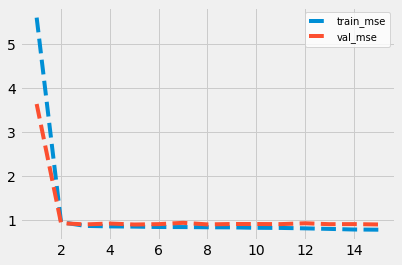

AFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  7.6039 - mse:  7.5904 - val_mse:  1.2397
Epoch 2/100
4s - loss:  1.1448 - mse:  1.1445 - val_mse:  1.1228
Epoch 3/100
4s - loss:  1.0685 - mse:  1.0682 - val_mse:  1.0662
Epoch 4/100
3s - loss:  1.0125 - mse:  1.0124 - val_mse:  1.0180
Epoch 5/100
3s - loss:  0.9512 - mse:  0.9512 - val_mse:  0.9574
Epoch 6/100
3s - loss:  0.8928 - mse:  0.8923 - val_mse:  0.9264
Epoch 7/100
3s - loss:  0.8639 - mse:  0.8635 - val_mse:  0.9144
Epoch 8/100
3s - loss:  0.8466 - mse:  0.8462 - val_mse:  0.9023
Epoch 9/100
3s - loss:  0.8345 - mse:  0.8342 - val_mse:  0.8960
Epoch 10/100
3s - loss:  0.8243 - mse:  0.8235 - val_mse:  0.8923
Epoch 11/100
3s - loss:  0.8158 - mse:  0.8155 - val_mse:  0.8887
Epoch 12/100
3s - loss:  0.8070 - mse:  0.8064 - val_mse:  0.8842
Epoch 13/100
4s - loss:  0.7997 - mse:  0.7989 - val_mse:  0.8823
Epoch 14/100
3s - loss:  0.7925 - mse:  0.7920 - val_mse:  0.8803
Epo

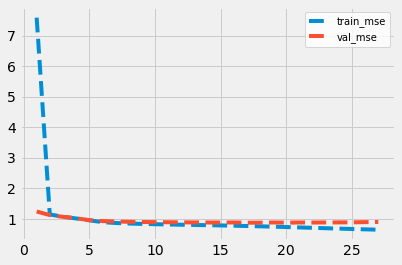

CCPM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  8.4180 - mse:  8.4139 - val_mse:  6.3492
Epoch 2/100
5s - loss:  1.6950 - mse:  1.6935 - val_mse:  1.3075
Epoch 3/100
5s - loss:  1.2700 - mse:  1.2703 - val_mse:  1.2785
Epoch 4/100
5s - loss:  1.2468 - mse:  1.2473 - val_mse:  1.2606
Epoch 5/100
5s - loss:  1.2233 - mse:  1.2231 - val_mse:  1.2409
Epoch 6/100
5s - loss:  1.1969 - mse:  1.1968 - val_mse:  1.2083
Epoch 7/100
5s - loss:  1.1632 - mse:  1.1629 - val_mse:  1.1694
Epoch 8/100
5s - loss:  1.1246 - mse:  1.1247 - val_mse:  1.1252
Epoch 9/100
5s - loss:  1.0763 - mse:  1.0767 - val_mse:  1.0789
Epoch 10/100
5s - loss:  1.0219 - mse:  1.0215 - val_mse:  1.0235
Epoch 11/100
5s - loss:  0.9636 - mse:  0.9636 - val_mse:  0.9813
Epoch 12/100
5s - loss:  0.9162 - mse:  0.9161 - val_mse:  0.9492
Epoch 13/100
5s - loss:  0.8814 - mse:  0.8812 - val_mse:  0.9162
Epoch 14/100
5s - loss:  0.8531 - mse:  0.8533 - val_mse:  0.9001
Ep

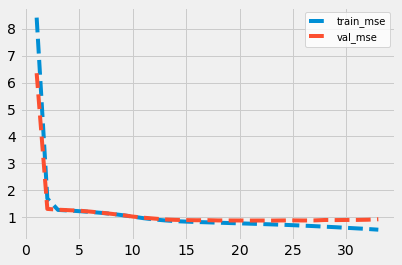

IPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
2s - loss:  8.9323 - mse:  8.9167 - val_mse:  1.2192
Epoch 2/100
2s - loss:  1.1061 - mse:  1.1061 - val_mse:  1.0560
Epoch 3/100
2s - loss:  0.9816 - mse:  0.9816 - val_mse:  0.9701
Epoch 4/100
2s - loss:  0.9091 - mse:  0.9090 - val_mse:  0.9252
Epoch 5/100
2s - loss:  0.8719 - mse:  0.8714 - val_mse:  0.9073
Epoch 6/100
2s - loss:  0.8546 - mse:  0.8541 - val_mse:  0.9000
Epoch 7/100
2s - loss:  0.8457 - mse:  0.8458 - val_mse:  0.8976
Epoch 8/100
2s - loss:  0.8412 - mse:  0.8411 - val_mse:  0.8956
Epoch 9/100
2s - loss:  0.8380 - mse:  0.8377 - val_mse:  0.8946
Epoch 10/100
2s - loss:  0.8359 - mse:  0.8355 - val_mse:  0.8946
Epoch 11/100
2s - loss:  0.8348 - mse:  0.8352 - val_mse:  0.8949
Epoch 12/100
2s - loss:  0.8336 - mse:  0.8331 - val_mse:  0.8954
Epoch 13/100
2s - loss:  0.8330 - mse:  0.8330 - val_mse:  0.8965
Epoch 14/100
2s - loss:  0.8324 - mse:  0.8322 - val_mse:  0.8952
Ep

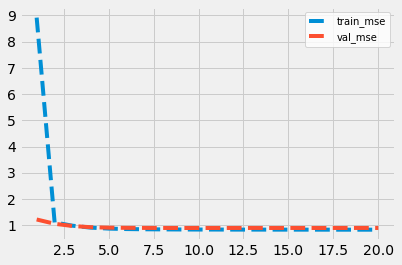

OPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  3.2393 - mse:  3.2354 - val_mse:  0.9243
Epoch 2/100
3s - loss:  0.8798 - mse:  0.8799 - val_mse:  0.8997
Epoch 3/100
3s - loss:  0.8623 - mse:  0.8621 - val_mse:  0.9008
Epoch 4/100
3s - loss:  0.8580 - mse:  0.8583 - val_mse:  0.8982
Epoch 5/100
3s - loss:  0.8553 - mse:  0.8553 - val_mse:  0.9006
Epoch 6/100
3s - loss:  0.8523 - mse:  0.8519 - val_mse:  0.9031
Epoch 7/100
3s - loss:  0.8506 - mse:  0.8502 - val_mse:  0.9000
Epoch 8/100
3s - loss:  0.8505 - mse:  0.8509 - val_mse:  0.9015
Epoch 9/100
3s - loss:  0.8497 - mse:  0.8498 - val_mse:  0.9021
Epoch 10/100
3s - loss:  0.8479 - mse:  0.8478 - val_mse:  0.8975
Epoch 11/100
3s - loss:  0.8467 - mse:  0.8466 - val_mse:  0.9036
Epoch 12/100
3s - loss:  0.8457 - mse:  0.8454 - val_mse:  0.8989
Epoch 13/100
3s - loss:  0.8451 - mse:  0.8446 - val_mse:  0.8988
Epoch 14/100
3s - loss:  0.8398 - mse:  0.8394 - val_mse:  0.8963
Ep

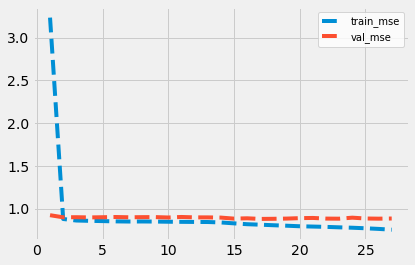

WDL
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  2.2435 - mse:  2.2410 - val_mse:  0.9227
Epoch 2/100
3s - loss:  0.8788 - mse:  0.8787 - val_mse:  0.9070
Epoch 3/100
4s - loss:  0.8671 - mse:  0.8671 - val_mse:  0.9001
Epoch 4/100
3s - loss:  0.8632 - mse:  0.8628 - val_mse:  0.9033
Epoch 5/100
4s - loss:  0.8599 - mse:  0.8599 - val_mse:  0.9028
Epoch 6/100
4s - loss:  0.8585 - mse:  0.8586 - val_mse:  0.8992
Epoch 7/100
4s - loss:  0.8557 - mse:  0.8555 - val_mse:  0.9111
Epoch 8/100
4s - loss:  0.8549 - mse:  0.8551 - val_mse:  0.9024
Epoch 9/100
4s - loss:  0.8560 - mse:  0.8566 - val_mse:  0.9189
Epoch 10/100
4s - loss:  0.8533 - mse:  0.8531 - val_mse:  0.8986
Epoch 11/100
4s - loss:  0.8518 - mse:  0.8515 - val_mse:  0.9185
Epoch 12/100
4s - loss:  0.8538 - mse:  0.8536 - val_mse:  0.9184
Epoch 13/100
4s - loss:  0.8503 - mse:  0.8504 - val_mse:  0.9037
Epoch 14/100
4s - loss:  0.8506 - mse:  0.8504 - val_mse:  0.9077
Epo

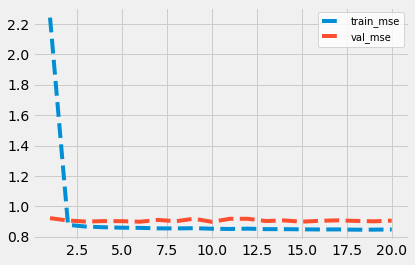

NFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.0511 - mse:  5.0429 - val_mse:  1.0464
Epoch 2/100
4s - loss:  0.9439 - mse:  0.9438 - val_mse:  0.9176
Epoch 3/100
4s - loss:  0.8646 - mse:  0.8649 - val_mse:  0.8989
Epoch 4/100
4s - loss:  0.8458 - mse:  0.8454 - val_mse:  0.8908
Epoch 5/100
4s - loss:  0.8365 - mse:  0.8363 - val_mse:  0.8900
Epoch 6/100
4s - loss:  0.8279 - mse:  0.8275 - val_mse:  0.8857
Epoch 7/100
6s - loss:  0.8186 - mse:  0.8181 - val_mse:  0.8842
Epoch 8/100
6s - loss:  0.8081 - mse:  0.8081 - val_mse:  0.8840
Epoch 9/100
7s - loss:  0.7982 - mse:  0.7978 - val_mse:  0.8787
Epoch 10/100
6s - loss:  0.7880 - mse:  0.7881 - val_mse:  0.8760
Epoch 11/100
5s - loss:  0.7775 - mse:  0.7776 - val_mse:  0.8733
Epoch 12/100
6s - loss:  0.7685 - mse:  0.7687 - val_mse:  0.8696
Epoch 13/100
6s - loss:  0.7596 - mse:  0.7594 - val_mse:  0.8682
Epoch 14/100
6s - loss:  0.7507 - mse:  0.7506 - val_mse:  0.8676
Epo

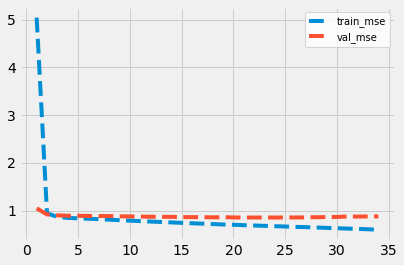

DCN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
6s - loss:  7.3140 - mse:  7.3083 - val_mse:  4.3910
Epoch 2/100
6s - loss:  0.9601 - mse:  0.9601 - val_mse:  0.9033
Epoch 3/100
6s - loss:  0.8589 - mse:  0.8588 - val_mse:  0.9045
Epoch 4/100
6s - loss:  0.8509 - mse:  0.8507 - val_mse:  0.9098
Epoch 5/100
6s - loss:  0.8431 - mse:  0.8429 - val_mse:  0.9047
Epoch 6/100
6s - loss:  0.8386 - mse:  0.8387 - val_mse:  0.9084
Epoch 7/100
5s - loss:  0.8396 - mse:  0.8399 - val_mse:  0.9102
Epoch 8/100
4s - loss:  0.8334 - mse:  0.8327 - val_mse:  0.9072
Epoch 9/100
4s - loss:  0.8315 - mse:  0.8313 - val_mse:  0.9004
Epoch 10/100
6s - loss:  0.8293 - mse:  0.8298 - val_mse:  0.9257
Epoch 11/100
7s - loss:  0.8277 - mse:  0.8278 - val_mse:  0.8963
Epoch 12/100
7s - loss:  0.8202 - mse:  0.8200 - val_mse:  0.8914
Epoch 13/100
6s - loss:  0.8166 - mse:  0.8168 - val_mse:  0.9105
Epoch 14/100
6s - loss:  0.8110 - mse:  0.8112 - val_mse:  0.8932
Epo

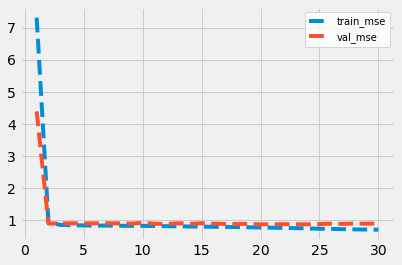

xDeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
6s - loss:  13.0894 - mse:  13.0769 - val_mse:  5.9668
Epoch 2/100
6s - loss:  1.0910 - mse:  1.0907 - val_mse:  0.9329
Epoch 3/100
5s - loss:  0.8690 - mse:  0.8692 - val_mse:  0.9073
Epoch 4/100
5s - loss:  0.8487 - mse:  0.8486 - val_mse:  0.9065
Epoch 5/100
5s - loss:  0.8430 - mse:  0.8431 - val_mse:  0.9074
Epoch 6/100
5s - loss:  0.8389 - mse:  0.8387 - val_mse:  0.9042
Epoch 7/100
5s - loss:  0.8369 - mse:  0.8365 - val_mse:  0.9078
Epoch 8/100
5s - loss:  0.8343 - mse:  0.8341 - val_mse:  0.9174
Epoch 9/100
5s - loss:  0.8327 - mse:  0.8327 - val_mse:  0.9022
Epoch 10/100
5s - loss:  0.8308 - mse:  0.8316 - val_mse:  0.9112
Epoch 11/100
5s - loss:  0.8311 - mse:  0.8310 - val_mse:  0.9033
Epoch 12/100
5s - loss:  0.8290 - mse:  0.8289 - val_mse:  0.9199
Epoch 13/100
5s - loss:  0.8295 - mse:  0.8299 - val_mse:  0.9108
Epoch 14/100
5s - loss:  0.8269 - mse:  0.8267 - val_mse:  0.91

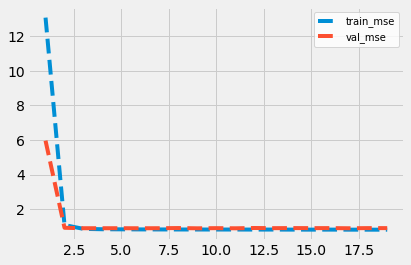

DIFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  11.4609 - mse:  11.4509 - val_mse:  6.7289
Epoch 2/100
5s - loss:  1.3035 - mse:  1.3023 - val_mse:  0.9422
Epoch 3/100
4s - loss:  0.8889 - mse:  0.8891 - val_mse:  0.9154
Epoch 4/100
4s - loss:  0.8759 - mse:  0.8756 - val_mse:  0.9394
Epoch 5/100
4s - loss:  0.8636 - mse:  0.8633 - val_mse:  0.9490
Epoch 6/100
4s - loss:  0.8512 - mse:  0.8512 - val_mse:  0.9605
Epoch 7/100
4s - loss:  0.8419 - mse:  0.8419 - val_mse:  0.9362
Epoch 8/100
4s - loss:  0.8344 - mse:  0.8342 - val_mse:  0.9445
Epoch 9/100
4s - loss:  0.8281 - mse:  0.8281 - val_mse:  0.9457
Epoch 10/100
4s - loss:  0.8154 - mse:  0.8154 - val_mse:  0.9189
Epoch 11/100
4s - loss:  0.8094 - mse:  0.8094 - val_mse:  0.9255
Epoch 12/100
4s - loss:  0.7998 - mse:  0.8000 - val_mse:  0.9374
Epoch 13/100
4s - loss:  0.7958 - mse:  0.7957 - val_mse:  0.9442
Epoch 00013: early stopping


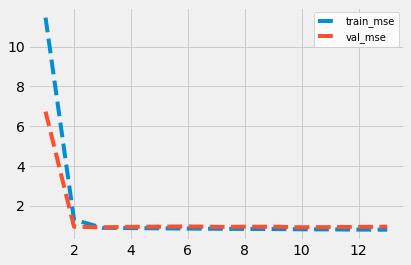

number: 3
DeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.6678 - mse:  5.6652 - val_mse:  3.6802
Epoch 2/100
4s - loss:  0.9550 - mse:  0.9547 - val_mse:  0.8913
Epoch 3/100
4s - loss:  0.8800 - mse:  0.8797 - val_mse:  0.9100
Epoch 4/100
4s - loss:  0.8680 - mse:  0.8680 - val_mse:  0.8894
Epoch 5/100
4s - loss:  0.8667 - mse:  0.8668 - val_mse:  0.8947
Epoch 6/100
4s - loss:  0.8581 - mse:  0.8578 - val_mse:  0.9012
Epoch 7/100
4s - loss:  0.8528 - mse:  0.8526 - val_mse:  0.8890
Epoch 8/100
4s - loss:  0.8485 - mse:  0.8485 - val_mse:  0.8981
Epoch 9/100
4s - loss:  0.8444 - mse:  0.8445 - val_mse:  0.8976
Epoch 10/100
4s - loss:  0.8387 - mse:  0.8391 - val_mse:  0.8922
Epoch 11/100
4s - loss:  0.8308 - mse:  0.8308 - val_mse:  0.8882
Epoch 12/100
4s - loss:  0.8199 - mse:  0.8199 - val_mse:  0.8856
Epoch 13/100
4s - loss:  0.8101 - mse:  0.8103 - val_mse:  0.8770
Epoch 14/100
4s - loss:  0.7983 - mse:  0.7985 - val_mse

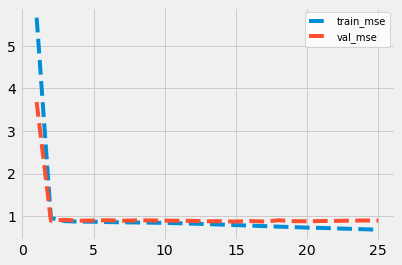

AFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  7.5477 - mse:  7.5342 - val_mse:  1.1921
Epoch 2/100
3s - loss:  1.1476 - mse:  1.1472 - val_mse:  1.0706
Epoch 3/100
3s - loss:  1.0569 - mse:  1.0563 - val_mse:  0.9971
Epoch 4/100
3s - loss:  0.9623 - mse:  0.9618 - val_mse:  0.9143
Epoch 5/100
3s - loss:  0.8902 - mse:  0.8896 - val_mse:  0.8893
Epoch 6/100
3s - loss:  0.8635 - mse:  0.8631 - val_mse:  0.8816
Epoch 7/100
3s - loss:  0.8487 - mse:  0.8478 - val_mse:  0.8741
Epoch 8/100
4s - loss:  0.8397 - mse:  0.8395 - val_mse:  0.8692
Epoch 9/100
4s - loss:  0.8323 - mse:  0.8317 - val_mse:  0.8664
Epoch 10/100
3s - loss:  0.8256 - mse:  0.8253 - val_mse:  0.8603
Epoch 11/100
3s - loss:  0.8196 - mse:  0.8187 - val_mse:  0.8567
Epoch 12/100
3s - loss:  0.8143 - mse:  0.8140 - val_mse:  0.8551
Epoch 13/100
3s - loss:  0.8089 - mse:  0.8081 - val_mse:  0.8529
Epoch 14/100
4s - loss:  0.8036 - mse:  0.8030 - val_mse:  0.8532
Epo

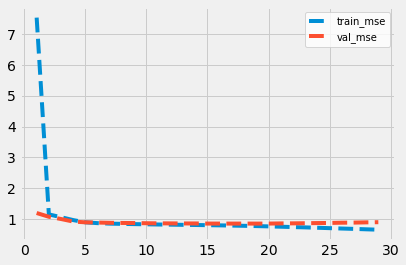

CCPM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  8.3803 - mse:  8.3758 - val_mse:  6.3426
Epoch 2/100
5s - loss:  1.4886 - mse:  1.4883 - val_mse:  1.2130
Epoch 3/100
5s - loss:  1.2156 - mse:  1.2149 - val_mse:  1.1688
Epoch 4/100
5s - loss:  1.1630 - mse:  1.1629 - val_mse:  1.0975
Epoch 5/100
5s - loss:  1.0687 - mse:  1.0682 - val_mse:  0.9967
Epoch 6/100
5s - loss:  0.9610 - mse:  0.9609 - val_mse:  0.9164
Epoch 7/100
5s - loss:  0.8953 - mse:  0.8955 - val_mse:  0.9229
Epoch 8/100
5s - loss:  0.8573 - mse:  0.8573 - val_mse:  0.8720
Epoch 9/100
5s - loss:  0.8329 - mse:  0.8325 - val_mse:  0.8607
Epoch 10/100
5s - loss:  0.8102 - mse:  0.8102 - val_mse:  0.8640
Epoch 11/100
5s - loss:  0.7983 - mse:  0.7985 - val_mse:  0.8645
Epoch 12/100
5s - loss:  0.7811 - mse:  0.7812 - val_mse:  0.8675
Epoch 13/100
5s - loss:  0.7680 - mse:  0.7677 - val_mse:  0.8554
Epoch 14/100
5s - loss:  0.7499 - mse:  0.7498 - val_mse:  0.8970
Ep

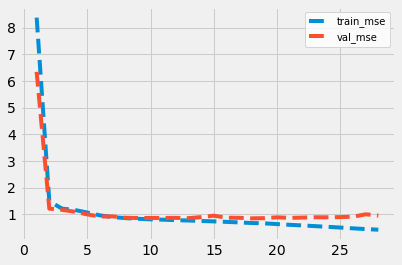

IPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
2s - loss:  8.9086 - mse:  8.8933 - val_mse:  1.1856
Epoch 2/100
3s - loss:  1.1164 - mse:  1.1158 - val_mse:  1.0229
Epoch 3/100
3s - loss:  0.9909 - mse:  0.9906 - val_mse:  0.9418
Epoch 4/100
2s - loss:  0.9181 - mse:  0.9179 - val_mse:  0.9008
Epoch 5/100
2s - loss:  0.8808 - mse:  0.8804 - val_mse:  0.8849
Epoch 6/100
2s - loss:  0.8634 - mse:  0.8632 - val_mse:  0.8796
Epoch 7/100
2s - loss:  0.8545 - mse:  0.8545 - val_mse:  0.8771
Epoch 8/100
2s - loss:  0.8499 - mse:  0.8499 - val_mse:  0.8765
Epoch 9/100
2s - loss:  0.8466 - mse:  0.8463 - val_mse:  0.8761
Epoch 10/100
2s - loss:  0.8448 - mse:  0.8442 - val_mse:  0.8765
Epoch 11/100
2s - loss:  0.8433 - mse:  0.8433 - val_mse:  0.8761
Epoch 12/100
2s - loss:  0.8425 - mse:  0.8429 - val_mse:  0.8764
Epoch 13/100
2s - loss:  0.8418 - mse:  0.8417 - val_mse:  0.8765
Epoch 14/100
2s - loss:  0.8412 - mse:  0.8411 - val_mse:  0.8764
Ep

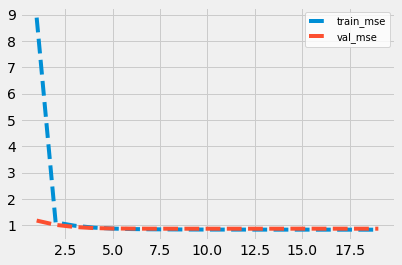

OPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  3.2443 - mse:  3.2397 - val_mse:  0.9074
Epoch 2/100
3s - loss:  0.8890 - mse:  0.8890 - val_mse:  0.8801
Epoch 3/100
3s - loss:  0.8720 - mse:  0.8718 - val_mse:  0.8902
Epoch 4/100
3s - loss:  0.8665 - mse:  0.8666 - val_mse:  0.8797
Epoch 5/100
3s - loss:  0.8636 - mse:  0.8635 - val_mse:  0.8881
Epoch 6/100
3s - loss:  0.8621 - mse:  0.8623 - val_mse:  0.8814
Epoch 7/100
3s - loss:  0.8605 - mse:  0.8607 - val_mse:  0.8794
Epoch 8/100
3s - loss:  0.8591 - mse:  0.8589 - val_mse:  0.8795
Epoch 9/100
3s - loss:  0.8570 - mse:  0.8568 - val_mse:  0.8780
Epoch 10/100
3s - loss:  0.8574 - mse:  0.8577 - val_mse:  0.8784
Epoch 11/100
3s - loss:  0.8559 - mse:  0.8559 - val_mse:  0.8781
Epoch 12/100
3s - loss:  0.8550 - mse:  0.8548 - val_mse:  0.8823
Epoch 13/100
3s - loss:  0.8526 - mse:  0.8525 - val_mse:  0.8769
Epoch 14/100
3s - loss:  0.8489 - mse:  0.8488 - val_mse:  0.8725
Ep

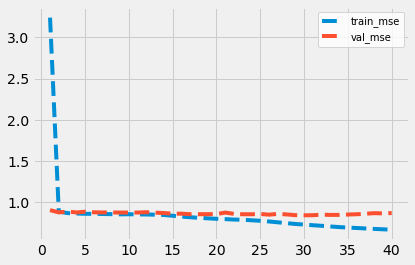

WDL
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  2.2535 - mse:  2.2512 - val_mse:  0.9010
Epoch 2/100
3s - loss:  0.8884 - mse:  0.8881 - val_mse:  0.8837
Epoch 3/100
3s - loss:  0.8755 - mse:  0.8751 - val_mse:  0.8897
Epoch 4/100
3s - loss:  0.8721 - mse:  0.8720 - val_mse:  0.8867
Epoch 5/100
3s - loss:  0.8716 - mse:  0.8715 - val_mse:  0.8842
Epoch 6/100
3s - loss:  0.8665 - mse:  0.8661 - val_mse:  0.8815
Epoch 7/100
3s - loss:  0.8656 - mse:  0.8655 - val_mse:  0.8984
Epoch 8/100
3s - loss:  0.8635 - mse:  0.8634 - val_mse:  0.8988
Epoch 9/100
4s - loss:  0.8645 - mse:  0.8645 - val_mse:  0.8812
Epoch 10/100
3s - loss:  0.8617 - mse:  0.8621 - val_mse:  0.8801
Epoch 11/100
3s - loss:  0.8614 - mse:  0.8613 - val_mse:  0.8794
Epoch 12/100
3s - loss:  0.8614 - mse:  0.8613 - val_mse:  0.8800
Epoch 13/100
3s - loss:  0.8578 - mse:  0.8579 - val_mse:  0.8833
Epoch 14/100
4s - loss:  0.8588 - mse:  0.8588 - val_mse:  0.8979
Epo

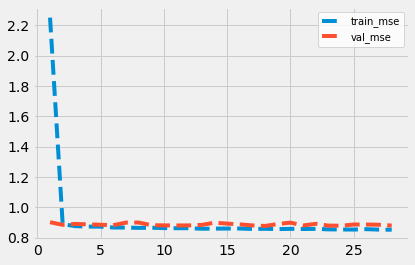

NFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.0376 - mse:  5.0293 - val_mse:  1.0117
Epoch 2/100
4s - loss:  0.9508 - mse:  0.9506 - val_mse:  0.8944
Epoch 3/100
3s - loss:  0.8740 - mse:  0.8740 - val_mse:  0.8769
Epoch 4/100
4s - loss:  0.8565 - mse:  0.8565 - val_mse:  0.8741
Epoch 5/100
4s - loss:  0.8480 - mse:  0.8477 - val_mse:  0.8724
Epoch 6/100
4s - loss:  0.8433 - mse:  0.8430 - val_mse:  0.8686
Epoch 7/100
3s - loss:  0.8387 - mse:  0.8384 - val_mse:  0.8689
Epoch 8/100
4s - loss:  0.8337 - mse:  0.8337 - val_mse:  0.8665
Epoch 9/100
4s - loss:  0.8290 - mse:  0.8285 - val_mse:  0.8649
Epoch 10/100
4s - loss:  0.8219 - mse:  0.8219 - val_mse:  0.8593
Epoch 11/100
4s - loss:  0.8145 - mse:  0.8144 - val_mse:  0.8576
Epoch 12/100
4s - loss:  0.8054 - mse:  0.8050 - val_mse:  0.8524
Epoch 13/100
4s - loss:  0.7948 - mse:  0.7946 - val_mse:  0.8481
Epoch 14/100
4s - loss:  0.7843 - mse:  0.7838 - val_mse:  0.8458
Epo

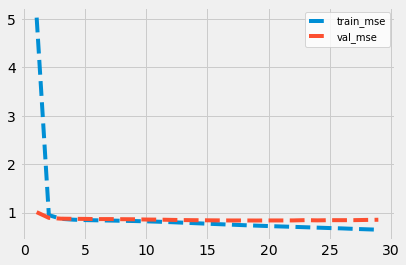

DCN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  7.1705 - mse:  7.1643 - val_mse:  4.0193
Epoch 2/100
4s - loss:  0.9566 - mse:  0.9568 - val_mse:  0.9380
Epoch 3/100
4s - loss:  0.8699 - mse:  0.8696 - val_mse:  0.8811
Epoch 4/100
4s - loss:  0.8596 - mse:  0.8595 - val_mse:  0.8871
Epoch 5/100
4s - loss:  0.8535 - mse:  0.8532 - val_mse:  0.8942
Epoch 6/100
4s - loss:  0.8485 - mse:  0.8485 - val_mse:  0.8910
Epoch 7/100
4s - loss:  0.8494 - mse:  0.8494 - val_mse:  0.8860
Epoch 8/100
4s - loss:  0.8409 - mse:  0.8409 - val_mse:  0.8845
Epoch 9/100
4s - loss:  0.8410 - mse:  0.8411 - val_mse:  0.8819
Epoch 10/100
4s - loss:  0.8340 - mse:  0.8335 - val_mse:  0.8823
Epoch 11/100
4s - loss:  0.8275 - mse:  0.8276 - val_mse:  0.8718
Epoch 12/100
4s - loss:  0.8156 - mse:  0.8154 - val_mse:  0.8665
Epoch 13/100
4s - loss:  0.8074 - mse:  0.8073 - val_mse:  0.8732
Epoch 14/100
4s - loss:  0.8018 - mse:  0.8017 - val_mse:  0.8569
Epo

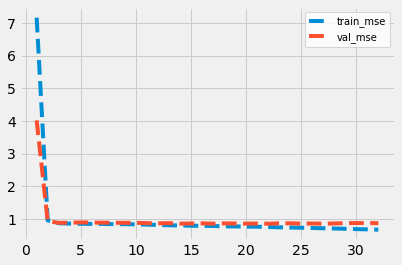

xDeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  13.0679 - mse:  13.0542 - val_mse:  5.9965
Epoch 2/100
6s - loss:  1.1166 - mse:  1.1164 - val_mse:  0.9016
Epoch 3/100
5s - loss:  0.8848 - mse:  0.8847 - val_mse:  0.8847
Epoch 4/100
5s - loss:  0.8629 - mse:  0.8627 - val_mse:  0.8923
Epoch 5/100
6s - loss:  0.8560 - mse:  0.8559 - val_mse:  0.8870
Epoch 6/100
5s - loss:  0.8503 - mse:  0.8503 - val_mse:  0.8990
Epoch 7/100
5s - loss:  0.8478 - mse:  0.8479 - val_mse:  0.8879
Epoch 8/100
5s - loss:  0.8448 - mse:  0.8444 - val_mse:  0.8952
Epoch 9/100
5s - loss:  0.8438 - mse:  0.8436 - val_mse:  0.9002
Epoch 10/100
5s - loss:  0.8430 - mse:  0.8424 - val_mse:  0.8868
Epoch 11/100
5s - loss:  0.8396 - mse:  0.8401 - val_mse:  0.8963
Epoch 12/100
5s - loss:  0.8395 - mse:  0.8397 - val_mse:  0.8979
Epoch 13/100
5s - loss:  0.8379 - mse:  0.8380 - val_mse:  0.8917
Epoch 00013: early stopping


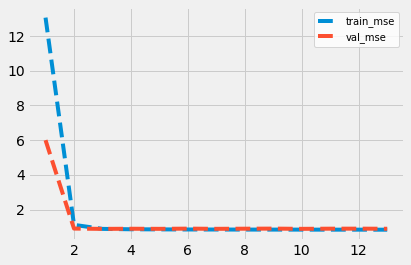

DIFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  11.4759 - mse:  11.4680 - val_mse:  6.8706
Epoch 2/100
5s - loss:  1.3617 - mse:  1.3610 - val_mse:  0.9315
Epoch 3/100
5s - loss:  0.8966 - mse:  0.8964 - val_mse:  0.8909
Epoch 4/100
5s - loss:  0.8793 - mse:  0.8792 - val_mse:  0.8960
Epoch 5/100
5s - loss:  0.8722 - mse:  0.8717 - val_mse:  0.9172
Epoch 6/100
5s - loss:  0.8655 - mse:  0.8655 - val_mse:  0.9155
Epoch 7/100
4s - loss:  0.8522 - mse:  0.8527 - val_mse:  1.0243
Epoch 8/100
4s - loss:  0.8433 - mse:  0.8431 - val_mse:  0.8911
Epoch 9/100
4s - loss:  0.8342 - mse:  0.8345 - val_mse:  0.9014
Epoch 10/100
4s - loss:  0.8240 - mse:  0.8241 - val_mse:  0.8792
Epoch 11/100
4s - loss:  0.8115 - mse:  0.8113 - val_mse:  0.8885
Epoch 12/100
4s - loss:  0.8002 - mse:  0.8003 - val_mse:  0.8798
Epoch 13/100
4s - loss:  0.7925 - mse:  0.7924 - val_mse:  0.8721
Epoch 14/100
5s - loss:  0.7869 - mse:  0.7870 - val_mse:  0.9062


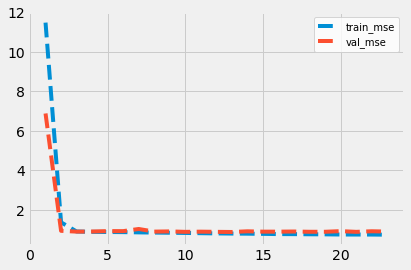

number: 4
DeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.6401 - mse:  5.6384 - val_mse:  3.6541
Epoch 2/100
4s - loss:  0.9596 - mse:  0.9595 - val_mse:  0.8866
Epoch 3/100
4s - loss:  0.8770 - mse:  0.8767 - val_mse:  0.9078
Epoch 4/100
4s - loss:  0.8623 - mse:  0.8621 - val_mse:  0.8973
Epoch 5/100
4s - loss:  0.8559 - mse:  0.8558 - val_mse:  0.8796
Epoch 6/100
4s - loss:  0.8508 - mse:  0.8512 - val_mse:  0.8829
Epoch 7/100
4s - loss:  0.8460 - mse:  0.8457 - val_mse:  0.8800
Epoch 8/100
4s - loss:  0.8414 - mse:  0.8415 - val_mse:  0.8794
Epoch 9/100
4s - loss:  0.8378 - mse:  0.8378 - val_mse:  0.8872
Epoch 10/100
4s - loss:  0.8311 - mse:  0.8312 - val_mse:  0.9058
Epoch 11/100
4s - loss:  0.8222 - mse:  0.8224 - val_mse:  0.8974
Epoch 12/100
4s - loss:  0.8162 - mse:  0.8164 - val_mse:  0.8999
Epoch 13/100
4s - loss:  0.8059 - mse:  0.8058 - val_mse:  0.8762
Epoch 14/100
4s - loss:  0.7937 - mse:  0.7934 - val_mse

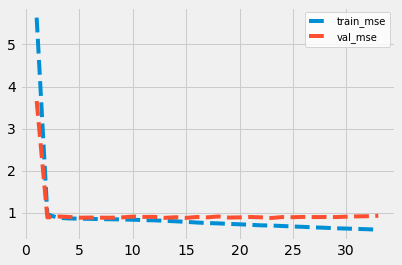

AFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  7.6880 - mse:  7.6745 - val_mse:  1.2396
Epoch 2/100
4s - loss:  1.1618 - mse:  1.1616 - val_mse:  1.1000
Epoch 3/100
4s - loss:  1.0775 - mse:  1.0773 - val_mse:  1.0428
Epoch 4/100
4s - loss:  1.0186 - mse:  1.0184 - val_mse:  0.9870
Epoch 5/100
3s - loss:  0.9432 - mse:  0.9433 - val_mse:  0.9230
Epoch 6/100
3s - loss:  0.8902 - mse:  0.8897 - val_mse:  0.8934
Epoch 7/100
3s - loss:  0.8628 - mse:  0.8626 - val_mse:  0.8786
Epoch 8/100
4s - loss:  0.8473 - mse:  0.8471 - val_mse:  0.8705
Epoch 9/100
4s - loss:  0.8366 - mse:  0.8363 - val_mse:  0.8664
Epoch 10/100
4s - loss:  0.8281 - mse:  0.8278 - val_mse:  0.8611
Epoch 11/100
4s - loss:  0.8206 - mse:  0.8202 - val_mse:  0.8584
Epoch 12/100
4s - loss:  0.8125 - mse:  0.8122 - val_mse:  0.8560
Epoch 13/100
4s - loss:  0.8062 - mse:  0.8061 - val_mse:  0.8544
Epoch 14/100
4s - loss:  0.8001 - mse:  0.7999 - val_mse:  0.8541
Epo

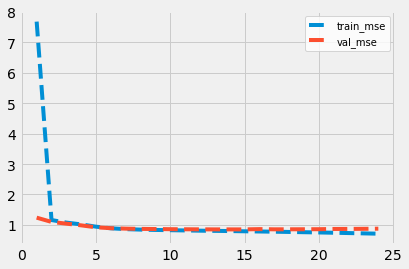

CCPM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  8.3534 - mse:  8.3489 - val_mse:  6.3805
Epoch 2/100
5s - loss:  1.4134 - mse:  1.4126 - val_mse:  1.2170
Epoch 3/100
5s - loss:  1.0906 - mse:  1.0907 - val_mse:  1.0197
Epoch 4/100
5s - loss:  0.9839 - mse:  0.9837 - val_mse:  0.9439
Epoch 5/100
5s - loss:  0.9100 - mse:  0.9100 - val_mse:  0.9279
Epoch 6/100
5s - loss:  0.8717 - mse:  0.8718 - val_mse:  0.9013
Epoch 7/100
5s - loss:  0.8434 - mse:  0.8433 - val_mse:  0.9000
Epoch 8/100
5s - loss:  0.8217 - mse:  0.8218 - val_mse:  0.8612
Epoch 9/100
5s - loss:  0.8102 - mse:  0.8104 - val_mse:  0.8657
Epoch 10/100
5s - loss:  0.7888 - mse:  0.7888 - val_mse:  0.8568
Epoch 11/100
5s - loss:  0.7830 - mse:  0.7827 - val_mse:  0.8500
Epoch 12/100
5s - loss:  0.7620 - mse:  0.7621 - val_mse:  0.8576
Epoch 13/100
5s - loss:  0.7436 - mse:  0.7434 - val_mse:  0.8984
Epoch 14/100
6s - loss:  0.7385 - mse:  0.7386 - val_mse:  0.8788
Ep

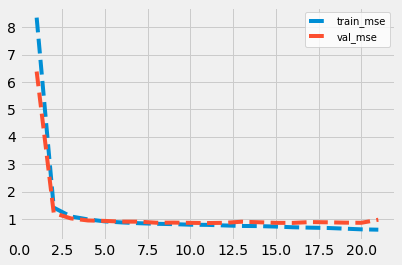

IPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  8.9348 - mse:  8.9190 - val_mse:  1.1854
Epoch 2/100
2s - loss:  1.1072 - mse:  1.1071 - val_mse:  1.0242
Epoch 3/100
3s - loss:  0.9846 - mse:  0.9847 - val_mse:  0.9409
Epoch 4/100
2s - loss:  0.9140 - mse:  0.9137 - val_mse:  0.8978
Epoch 5/100
2s - loss:  0.8770 - mse:  0.8767 - val_mse:  0.8796
Epoch 6/100
2s - loss:  0.8594 - mse:  0.8590 - val_mse:  0.8735
Epoch 7/100
3s - loss:  0.8506 - mse:  0.8506 - val_mse:  0.8705
Epoch 8/100
3s - loss:  0.8460 - mse:  0.8457 - val_mse:  0.8689
Epoch 9/100
3s - loss:  0.8431 - mse:  0.8430 - val_mse:  0.8680
Epoch 10/100
3s - loss:  0.8409 - mse:  0.8405 - val_mse:  0.8678
Epoch 11/100
3s - loss:  0.8395 - mse:  0.8392 - val_mse:  0.8678
Epoch 12/100
3s - loss:  0.8387 - mse:  0.8387 - val_mse:  0.8669
Epoch 13/100
2s - loss:  0.8378 - mse:  0.8375 - val_mse:  0.8680
Epoch 14/100
3s - loss:  0.8370 - mse:  0.8371 - val_mse:  0.8676
Ep

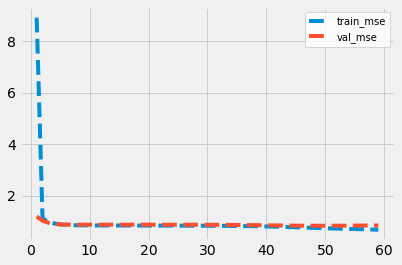

OPNN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  3.2432 - mse:  3.2383 - val_mse:  0.9026
Epoch 2/100
3s - loss:  0.8845 - mse:  0.8852 - val_mse:  0.8775
Epoch 3/100
3s - loss:  0.8686 - mse:  0.8688 - val_mse:  0.8726
Epoch 4/100
3s - loss:  0.8622 - mse:  0.8620 - val_mse:  0.8728
Epoch 5/100
3s - loss:  0.8595 - mse:  0.8591 - val_mse:  0.8731
Epoch 6/100
3s - loss:  0.8578 - mse:  0.8579 - val_mse:  0.8703
Epoch 7/100
3s - loss:  0.8567 - mse:  0.8571 - val_mse:  0.8728
Epoch 8/100
3s - loss:  0.8548 - mse:  0.8546 - val_mse:  0.8723
Epoch 9/100
3s - loss:  0.8539 - mse:  0.8539 - val_mse:  0.8745
Epoch 10/100
3s - loss:  0.8517 - mse:  0.8517 - val_mse:  0.8746
Epoch 11/100
3s - loss:  0.8510 - mse:  0.8509 - val_mse:  0.8713
Epoch 12/100
3s - loss:  0.8503 - mse:  0.8502 - val_mse:  0.8710
Epoch 13/100
3s - loss:  0.8483 - mse:  0.8483 - val_mse:  0.8680
Epoch 14/100
3s - loss:  0.8443 - mse:  0.8438 - val_mse:  0.8621
Ep

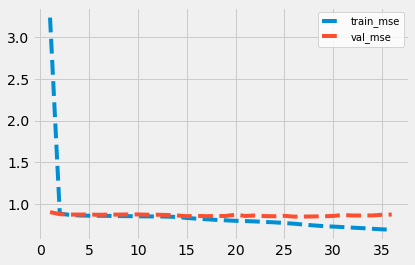

WDL
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
3s - loss:  2.2254 - mse:  2.2226 - val_mse:  0.8881
Epoch 2/100
3s - loss:  0.8845 - mse:  0.8845 - val_mse:  0.8775
Epoch 3/100
3s - loss:  0.8734 - mse:  0.8730 - val_mse:  0.8796
Epoch 4/100
3s - loss:  0.8678 - mse:  0.8674 - val_mse:  0.8767
Epoch 5/100
4s - loss:  0.8668 - mse:  0.8668 - val_mse:  0.8770
Epoch 6/100
4s - loss:  0.8669 - mse:  0.8671 - val_mse:  0.8761
Epoch 7/100
4s - loss:  0.8608 - mse:  0.8604 - val_mse:  0.8725
Epoch 8/100
4s - loss:  0.8596 - mse:  0.8596 - val_mse:  0.8750
Epoch 9/100
4s - loss:  0.8591 - mse:  0.8589 - val_mse:  0.8820
Epoch 10/100
3s - loss:  0.8589 - mse:  0.8590 - val_mse:  0.8858
Epoch 11/100
3s - loss:  0.8589 - mse:  0.8589 - val_mse:  0.8789
Epoch 12/100
3s - loss:  0.8556 - mse:  0.8556 - val_mse:  0.8736
Epoch 13/100
4s - loss:  0.8579 - mse:  0.8577 - val_mse:  0.8685
Epoch 14/100
4s - loss:  0.8549 - mse:  0.8545 - val_mse:  0.8869
Epo

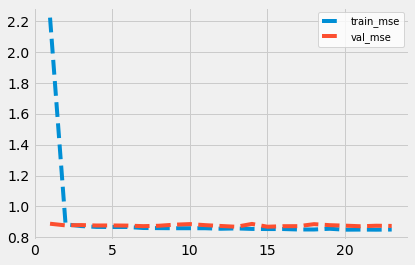

NFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
4s - loss:  5.0875 - mse:  5.0795 - val_mse:  1.0158
Epoch 2/100
4s - loss:  0.9471 - mse:  0.9470 - val_mse:  0.8888
Epoch 3/100
4s - loss:  0.8681 - mse:  0.8681 - val_mse:  0.8691
Epoch 4/100
4s - loss:  0.8472 - mse:  0.8473 - val_mse:  0.8662
Epoch 5/100
4s - loss:  0.8353 - mse:  0.8351 - val_mse:  0.8550
Epoch 6/100
4s - loss:  0.8254 - mse:  0.8255 - val_mse:  0.8551
Epoch 7/100
4s - loss:  0.8176 - mse:  0.8177 - val_mse:  0.8520
Epoch 8/100
4s - loss:  0.8083 - mse:  0.8086 - val_mse:  0.8483
Epoch 9/100
4s - loss:  0.7997 - mse:  0.7995 - val_mse:  0.8472
Epoch 10/100
4s - loss:  0.7901 - mse:  0.7899 - val_mse:  0.8442
Epoch 11/100
4s - loss:  0.7797 - mse:  0.7793 - val_mse:  0.8402
Epoch 12/100
5s - loss:  0.7681 - mse:  0.7681 - val_mse:  0.8406
Epoch 13/100
5s - loss:  0.7574 - mse:  0.7571 - val_mse:  0.8386
Epoch 14/100
4s - loss:  0.7449 - mse:  0.7447 - val_mse:  0.8355
Epo

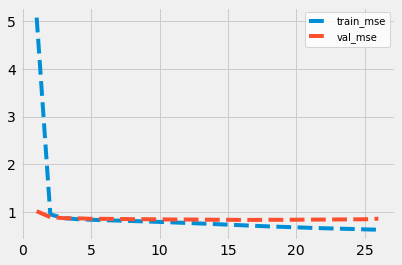

DCN
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
5s - loss:  7.3358 - mse:  7.3306 - val_mse:  4.3331
Epoch 2/100
5s - loss:  0.9808 - mse:  0.9803 - val_mse:  0.8906
Epoch 3/100
4s - loss:  0.8706 - mse:  0.8705 - val_mse:  0.8752
Epoch 4/100
5s - loss:  0.8639 - mse:  0.8640 - val_mse:  0.8726
Epoch 5/100
5s - loss:  0.8542 - mse:  0.8542 - val_mse:  0.8870
Epoch 6/100
5s - loss:  0.8492 - mse:  0.8488 - val_mse:  0.8810
Epoch 7/100
5s - loss:  0.8463 - mse:  0.8462 - val_mse:  0.8840
Epoch 8/100
5s - loss:  0.8424 - mse:  0.8421 - val_mse:  0.8756
Epoch 9/100
5s - loss:  0.8409 - mse:  0.8409 - val_mse:  0.8723
Epoch 10/100
5s - loss:  0.8400 - mse:  0.8401 - val_mse:  0.8731
Epoch 11/100
5s - loss:  0.8365 - mse:  0.8365 - val_mse:  0.8732
Epoch 12/100
5s - loss:  0.8326 - mse:  0.8328 - val_mse:  0.8722
Epoch 13/100
5s - loss:  0.8293 - mse:  0.8293 - val_mse:  0.8801
Epoch 14/100
5s - loss:  0.8283 - mse:  0.8285 - val_mse:  0.8728
Epo

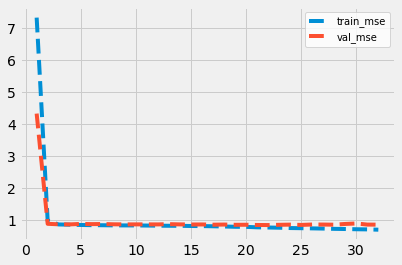

xDeepFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
7s - loss:  13.0779 - mse:  13.0648 - val_mse:  5.9089
Epoch 2/100
7s - loss:  1.0787 - mse:  1.0785 - val_mse:  0.9087
Epoch 3/100
6s - loss:  0.8763 - mse:  0.8767 - val_mse:  0.8850
Epoch 4/100
6s - loss:  0.8570 - mse:  0.8568 - val_mse:  0.8798
Epoch 5/100
6s - loss:  0.8487 - mse:  0.8488 - val_mse:  0.8782
Epoch 6/100
6s - loss:  0.8443 - mse:  0.8446 - val_mse:  0.8773
Epoch 7/100
6s - loss:  0.8433 - mse:  0.8433 - val_mse:  0.8792
Epoch 8/100
6s - loss:  0.8388 - mse:  0.8388 - val_mse:  0.8946
Epoch 9/100
6s - loss:  0.8381 - mse:  0.8382 - val_mse:  0.8896
Epoch 10/100
6s - loss:  0.8366 - mse:  0.8366 - val_mse:  0.8797
Epoch 11/100
6s - loss:  0.8337 - mse:  0.8337 - val_mse:  0.8849
Epoch 12/100
6s - loss:  0.8353 - mse:  0.8353 - val_mse:  0.8755
Epoch 13/100
6s - loss:  0.8319 - mse:  0.8320 - val_mse:  0.8779
Epoch 14/100
6s - loss:  0.8323 - mse:  0.8324 - val_mse:  0.87

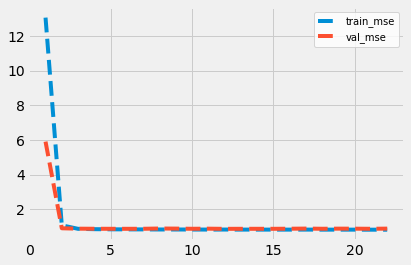

DIFM
cuda:0
Train on 70000 samples, validate on 10000 samples, 274 steps per epoch
Epoch 1/100
6s - loss:  11.4206 - mse:  11.4096 - val_mse:  6.6582
Epoch 2/100
5s - loss:  1.4287 - mse:  1.4278 - val_mse:  0.8935
Epoch 3/100
5s - loss:  0.8855 - mse:  0.8854 - val_mse:  0.9001
Epoch 4/100
5s - loss:  0.8770 - mse:  0.8773 - val_mse:  0.8759
Epoch 5/100
5s - loss:  0.8586 - mse:  0.8588 - val_mse:  0.8896
Epoch 6/100
5s - loss:  0.8548 - mse:  0.8545 - val_mse:  0.9160
Epoch 7/100
5s - loss:  0.8489 - mse:  0.8490 - val_mse:  0.9041
Epoch 8/100
6s - loss:  0.8438 - mse:  0.8438 - val_mse:  0.9596
Epoch 9/100
5s - loss:  0.8286 - mse:  0.8284 - val_mse:  0.8942
Epoch 10/100
5s - loss:  0.8242 - mse:  0.8245 - val_mse:  0.8844
Epoch 11/100
5s - loss:  0.8109 - mse:  0.8108 - val_mse:  0.8787
Epoch 12/100
5s - loss:  0.8009 - mse:  0.8007 - val_mse:  0.8966
Epoch 13/100
5s - loss:  0.7961 - mse:  0.7963 - val_mse:  0.8885
Epoch 14/100
5s - loss:  0.7826 - mse:  0.7826 - val_mse:  0.9307


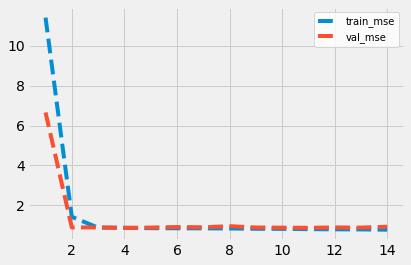

In [44]:
for i in range(1,5):
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))
    
    train_x = sparse_x[train_ind]
    val_x = sparse_x[val_ind]
    test_x = sparse_x[test_ind]

    train_y=target[train_ind]
    val_y=target[val_ind]
    test_y=target[test_ind]
    
    train_x_tensor = sparse2tensor(train_x)
    val_x_tensor = sparse2tensor(val_x)
    test_x_tensor = sparse2tensor(test_x)
    
    print('==================================================')
    print('number:', i)
    print('DeepFM')
    DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('AFM')
    AFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('CCPM')
    CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('IPNN')
    IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('OPNN')
    OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('WDL')
    WDL_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('NFM')
    NFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DCN')
    DCN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('xDeepFM')
    xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DIFM')
    DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y)

In [45]:
model_list = ['deepfm', 'AFM', 'CCPM',
             'OPNN', 'IPNN', 'wide_deep',
             'NFM', 'DCN', 'xDeepFM', 'DIFM']

In [61]:
def get_train(data, train_ind):
    
    train_data = data.loc[train_ind][data.columns[:3]]
    train_data = train_data.rename(columns={train_data.columns[1]: "item"})
    train_user = train_data.user.value_counts().index.to_numpy()
    train_user = np.sort(train_user)
    
    return train_data, train_user

def get_test_val(data, test_ind):

    test_data = data.loc[test_ind][data.columns[:3]]
    test_data = test_data.rename(columns={test_data.columns[1]: "item"})
    test_user = test_data.user.value_counts().index.to_numpy()
    test_user = np.sort(test_user)

    #count interation in test set
    test_inter_count ={} 
    interaction = test_data.user.value_counts()

    for i, count in enumerate(interaction):
        if count >= 10:
            test_inter_count[interaction.index[i]] = 10
        else:
            test_inter_count[interaction.index[i]] = count
            
    return test_data, test_user, test_inter_count

In [62]:
def ctr(m_path):

    model = torch.load(m_path)
    model.to(device)
    torch.backends.cudnn.benchmark = True
    
    rate = model.predict(test_x_tensor.to(device))
    rate = rate.reshape(rate.shape[0], )

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [63]:
result_dict = {}
for name in model_list:
    result_dict[name] = []

model_root = 'C:/Users/bbb50/Desktop/Python/hw3/Movielens/model/'

for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))
    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    test_x = sparse_x[test_ind]
    test_y=target[test_ind]
    test_x_tensor = sparse2tensor(test_x)
    
    for model_name in model_list: 
        print('=================================================================')
        print(model_name)
        model_path = os.path.join(model_root, model_name, str(i))
        fil_arr = [list(map(lambda x: model_name in x, listdir(model_path)))]
        model_file = np.array(listdir(model_path))[fil_arr]
        mfile_ind = list(map(lambda x: int(x.split('-')[0].split('_')[-1]), model_file))
        m_path = os.path.join(model_path, model_file[np.argmax(np.array(mfile_ind))])
        rmse, recall, ndcg = ctr(m_path)
        result_dict[model_name] = result_dict[model_name] + [[rmse, recall, ndcg]]


num: 0
deepfm


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 760.76it/s]


AFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 765.30it/s]


CCPM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 790.87it/s]


OPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 671.85it/s]


IPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 628.66it/s]


wide_deep


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 688.18it/s]


NFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 746.96it/s]


DCN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 714.80it/s]


xDeepFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 760.00it/s]


DIFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 711.14it/s]


num: 1
deepfm


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 748.01it/s]


AFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 674.26it/s]


CCPM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 623.95it/s]


OPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 690.76it/s]


IPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 746.04it/s]


wide_deep


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 808.89it/s]


NFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 819.25it/s]


DCN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 825.25it/s]


xDeepFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 802.68it/s]


DIFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 801.98it/s]


num: 2
deepfm


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 780.50it/s]


AFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 765.40it/s]


CCPM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 789.20it/s]


OPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 710.20it/s]


IPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 659.43it/s]


wide_deep


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 658.77it/s]


NFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 617.51it/s]


DCN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 726.50it/s]


xDeepFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 683.63it/s]


DIFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 711.72it/s]


num: 3
deepfm


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 613.14it/s]


AFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 717.35it/s]


CCPM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 625.28it/s]


OPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 645.10it/s]


IPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 699.02it/s]


wide_deep


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 811.86it/s]


NFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 778.01it/s]


DCN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 748.33it/s]


xDeepFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 642.05it/s]


DIFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 706.70it/s]


num: 4
deepfm


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 798.01it/s]


AFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 797.51it/s]


CCPM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 776.97it/s]


OPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 766.92it/s]


IPNN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 754.98it/s]


wide_deep


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 796.97it/s]


NFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 766.81it/s]


DCN


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 786.62it/s]


xDeepFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 817.68it/s]


DIFM


100%|███████████████████████████████████████████████████████████████████████████████| 943/943 [00:01<00:00, 802.00it/s]


In [64]:
result_dict

{'deepfm': [[0.9379482096073146, 0.7776923530104866, 0.955554317801697],
  [0.9463829495867172, 0.8046209328552912, 0.9556101291899916],
  [0.9522206342432821, 0.7679875944722181, 0.9537286054296591],
  [0.9294948164226021, 0.7774886801663048, 0.9562563569566102],
  [0.9429916453740257, 0.8212206904677741, 0.9569097055000448]],
 'AFM': [[0.9256253117244371, 0.7587166927569897, 0.9553802095311633],
  [0.9487888436107602, 0.7763684795233046, 0.9545896453608766],
  [0.9317326416627161, 0.7710986550859297, 0.9547989845620519],
  [0.9224726498789482, 0.7763394435186588, 0.9549665380887913],
  [0.9362454327500849, 0.801374370886566, 0.9557669496003863]],
 'CCPM': [[0.9302097558686354, 0.8129012439192714, 0.9555328579076361],
  [0.9385699540103822, 0.798111397263041, 0.9556087417104447],
  [0.9325103714461352, 0.7779751384470366, 0.9552774782267345],
  [0.91967295082051, 0.7817822215489235, 0.9561683494518922],
  [0.9337450956998975, 0.7798902523186723, 0.9555557826482042]],
 'OPNN': [[0.9274

In [65]:
for name in model_list:
    print(name, np.array(result_dict[name]).mean(axis=0))
    

deepfm [0.94180765 0.78980205 0.95561182]
AFM [0.93297298 0.77677953 0.95510047]
CCPM [0.93094163 0.79013205 0.95562864]
OPNN [0.93177085 0.79640728 0.95395396]
IPNN [0.93633299 0.77778998 0.95528079]
wide_deep [0.94409338 0.77839646 0.95396419]
NFM [0.92361662 0.80137403 0.95737967]
DCN [0.93553015 0.80452457 0.95523855]
xDeepFM [0.9475173  0.77810121 0.95370267]
DIFM [0.945789   0.76194482 0.95325471]


In [50]:
from os import listdir
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
m = torch.load('test.ckpt')

In [33]:
m.predict(test_x_tensor)

array([[4.00951767],
       [3.93800592],
       [4.28843737],
       ...,
       [4.74223948],
       [3.6681757 ],
       [3.4003098 ]])